## Download Dataset

In [1]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/KaggleAPI/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [2]:
!pip install -q kaggle
!kaggle datasets list
!kaggle competitions download -c hackathon-online-2022-image-processing #download competition dataset
!unzip /content/hackathon-online-2022-image-processing.zip
!mkdir /content/zipfile
!unzip /content/IM_Test.zipfile -d /content/zipfile
!unzip /content/IM_Train.zipfile -d /content/zipfile
!mkdir /content/dataset/
!unzip /content/zipfile/IM_Train.zipfile -d /content/dataset
!unzip /content/zipfile/IM_Test.zipfile -d /content/dataset/test
!rm -r /content/zipfile

Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset/test/IM_Test/IM_Test/5499.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/55.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/550.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5500.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5501.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5502.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5503.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5504.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5505.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5506.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5507.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5508.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5509.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/551.png  
 extracting: /content/dataset/test/IM_Test/IM_Test/5510.png  
 extracting: /content/d

In [3]:
# !kaggle competitions submit -c hackathon-online-2022-image-processing -f /content/IM_Submit.csv -m "test send submit file from colab"

## **Import and Preprocess Dataset**
Do an image augmentation which consist of rotation, width/height shift, shear and zoom. Then split the dataset 20% as validation dataset and 80% as train dataset.

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
def getImgWnH(path):
  W,H = [],[]
  for fold in os.listdir(path):
    for ele in os.listdir(os.path.join(path,fold)):
      img = cv2.imread(os.path.join(path,fold)+f"/{ele}")
      w,h,c= img.shape
      del(c)
      W.append(w)
      H.append(h)
  return W,H

def dropImgCustomWnH(path,max_wh,min_wh):
  for fold in os.listdir(path):
    for ele in os.listdir(os.path.join(path,fold)):
      img = cv2.imread(os.path.join(path,fold)+f"/{ele}")
      w,h,c= img.shape
      del(c)
      if w < min_wh or h < min_wh or w > max_wh or h > max_wh:
        os.remove(os.path.join(path,fold)+f"/{ele}")

W 423 10
H 741 1


Text(0, 0.5, 'H')

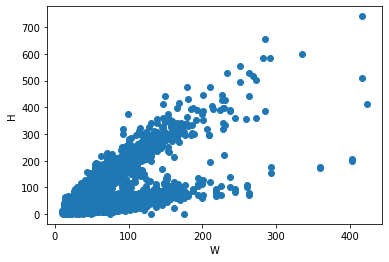

In [6]:
train_dir = '/content/dataset/train'

W,H = getImgWnH(train_dir)

print("W",max(W),min(W))
print("H",max(H),min(H))
plt.scatter(W,H)
plt.xlabel("W")
plt.ylabel("H")

W 120 16
H 120 16


Text(0, 0.5, 'H')

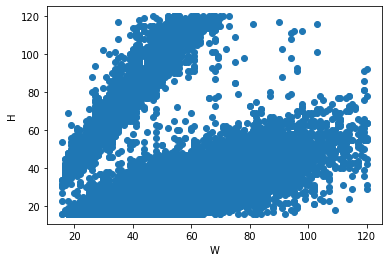

In [7]:
train_dir = '/content/dataset/train'

max_wh,min_wh = 120,16

dropImgCustomWnH(train_dir,max_wh,min_wh)
W,H = getImgWnH(train_dir)

print("W",max(W),min(W))
print("H",max(H),min(H))
plt.scatter(W,H)
plt.xlabel("W")
plt.ylabel("H")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/dataset/train'
w ,h = 150,150
# image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest',
      validation_split=0.2)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(w, h),  # All images will be resized to 32x32
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(w, h),
        batch_size=64,
        class_mode='categorical',
        subset='validation')

Found 25461 images belonging to 10 classes.
Found 6360 images belonging to 10 classes.


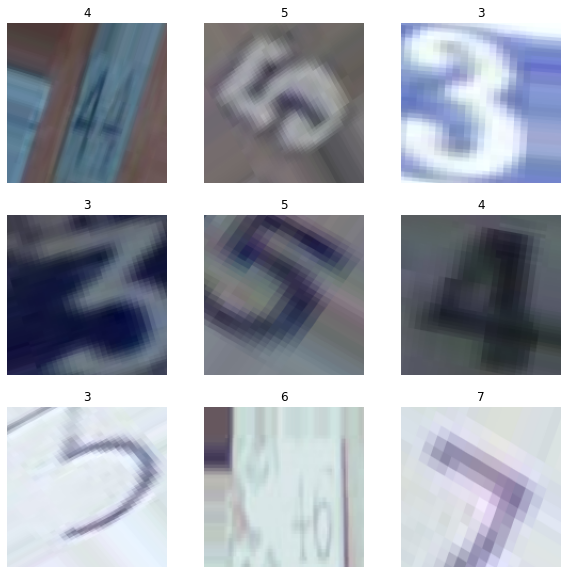

In [9]:
plt.figure(figsize=(10, 10))

for var in range(9):

  ax = plt.subplot(3, 3, var + 1)
  randint = np.random.randint(0,len(train_generator[0][0]))
  plt.imshow(np.array(train_generator[0][0][randint]))
  plt.title(train_generator[0][1][randint].argmax())
  plt.axis("off")

In [10]:
len(train_generator[0][1])

64

## **Prepare a Model**
In this version I used transfer learning technique from RestNet50 and fine tuning by add Flatten, Dropout, Dense layers.

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check accuracy
    if(logs.get('val_accuracy') > 0.94):

      # Stop if threshold is met
      print("\nDOING CALLBACK")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [13]:
RestNet50 = tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet',classes=10)

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(w,h,3)),
    RestNet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
# model.add(tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet',classes=10))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# callbacks = tf.keras.callbacks.EarlyStopping(
#             monitor = 'val_accuracy',
#             min_delta = 0.05,
#             patience = 5,
#             mode = 'auto',
#             restore_best_weights = True)

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            callbacks=callbacks,
            verbose = 1)

Epoch 1/100
  6/100 [>.............................] - ETA: 31s - loss: 2.8817 - accuracy: 0.2109

100/100 [==============================] - 66s 513ms/step - loss: 1.5417 - accuracy: 0.5038 - val_loss: 3.1155 - val_accuracy: 0.1253
Epoch 2/100
100/100 [==============================] - 51s 506ms/step - loss: 0.7559 - accuracy: 0.7573 - val_loss: 2.2916 - val_accuracy: 0.1450
Epoch 3/100
100/100 [==============================] - 53s 527ms/step - loss: 0.5893 - accuracy: 0.8078 - val_loss: 2.3030 - val_accuracy: 0.1528
Epoch 4/100
100/100 [==============================] - 51s 507ms/step - loss: 0.5120 - accuracy: 0.8375 - val_loss: 2.3572 - val_accuracy: 0.1269
Epoch 5/100
100/100 [==============================] - 51s 507ms/step - loss: 0.4962 - accuracy: 0.8470 - val_loss: 2.3556 - val_accuracy: 0.1184
Epoch 6/100
100/100 [==============================] - 52s 515ms/step - loss: 0.4782 - accuracy: 0.8508 - val_loss: 2.2636 - val_accuracy: 0.1406
Epoch 7/100
100/100 [==============================] - 51s 513ms/step - loss: 0.4562 - accuracy: 0.8589 - val_loss: 1.5365 - val_accurac

In [ ]:
model.save('/content/drive/MyDrive/saved_model/03model')
model.save('/content/drive/MyDrive/saved_model/03model/03model.h5')

In [ ]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
plot_loss_acc(history)
# plot_loss_acc(new_model)

## **TEST**

In [ ]:
import os
import numpy as np
import tensorflow as tf

In [ ]:
# new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/03model/03model.h5')
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/03model')
new_model.summary()

In [ ]:
from PIL import Image
import json

def jsonCustomFormatter(data) -> [list,list]:
  filename= []
  for name in range(len(data)):
      for bbox in range(len(data[name]['bboxes'])):
          _name = data[name]['filename'].split('.')[0]+ "_" + str(data[name]['bboxes'][bbox]['bbox_id'])
          filename.append(_name)

  bboxes= []
  # (left, top, right, bottom)
  for name in range(len(data)):
      for bbox in range(len(data[name]['bboxes'])):
          _coor = []
          _coor.append(data[name]['bboxes'][bbox]['x1'])
          _coor.append(data[name]['bboxes'][bbox]['y1'])
          _coor.append(data[name]['bboxes'][bbox]['x2'])
          _coor.append(data[name]['bboxes'][bbox]['y2'])
          bboxes.append(_coor)

  return filename,bboxes


def normImg(imgArray):
  imgArray = imgArray / 255.
  return imgArray


def loadTestImage(path,test_filename,bboxes,w=300,h=300,):
  test_img = []
  for ele in range(len(test_filename)):
    img = Image.open(os.path.join(path,str(test_filename[ele].split('_')[0]))+".png")
    img = img.crop(bboxes[ele])
    img = img.resize((w,h))
    img = np.array(img)
    img = normImg(img)
    test_img.append(img)

  return np.array(test_img)


def JSONReader(json_path):
  f = open(json_path)
  with open(json_path, 'r', encoding='utf-8') as f:
      data = json.load(f)
  f.close()

  filename,bboxes = jsonCustomFormatter(data=data)
  del(data)

  return filename,bboxes


def BatchTest(path,filename,bboxes,model,w,h,batch_size):
  pred_res = []
  start = 0
  final = batch_size
  round = int(len(filename)/batch_size)
  for i in range(round):
    try:
      test_img = loadTestImage(path,filename[int(start):int(final)],bboxes[int(start):int(final)],w,h)
      pred = model.predict(test_img)
      del(test_img)
      _pred_res = [ele.argmax() for ele in pred]

      for ele in _pred_res:
        pred_res.append(ele)
      start = final
      final = final + batch_size
    except LookupError:  
      print ("Index Error Exception Raised, list index out of range")

  return pred_res


In [ ]:
json_path = '/content/dataset/test/IM_Test/IM_Test.json'

filename,bboxes = JSONReader(json_path)

len(filename),len(bboxes)

In [ ]:
test_path = '/content/dataset/test/IM_Test/IM_Test'
w ,h = 150,150

pred_res = BatchTest(test_path,filename,bboxes,new_model,w,h,len(filename)/2)

In [ ]:
# test_path = '/content/dataset/test/IM_Test/IM_Test'
# w ,h = 150,150
# pred_res = []
# test_img = np.array(loadTestImage(test_path,filename[0:int(len(filename)/2)],bboxes[0:int(len(filename)/2)] ,w=w,h=h))
# pred = model.predict(test_img)
# _pred_res = [x.argmax() for x in pred]
# for x in _pred_res:
#   pred_res.append(x)


# del(test_img)
# del(pred)

In [ ]:
# test_img = np.array(loadTestData(test_path,filename[int(len(filename)/2):],bboxes[int(len(filename)/2):] ,w=w,h=h))
# pred = model.predict(test_img)
# _pred_res = [x.argmax() for x in pred]
# for x in _pred_res:
#   pred_res.append(x)

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Submit/IM_Submit.csv')
df['class'] = pred_res

df['imageid_boxid']

In [ ]:
df.to_csv('/content/drive/MyDrive/Submit/IM_Submit06.csv',index=False)

In [ ]:
!kaggle competitions submit -c hackathon-online-2022-image-processing -f /content/drive/MyDrive/Submit/IM_Submit06.csv -m "Machine(s) learning I learned nothing"